<a href="https://colab.research.google.com/github/shufan6011/GW-Event-Detection/blob/main/Step_4_CNNs_for_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Update:
# Use GPU instead of CPU for faster model training

# Data Preprocessing & functions

In [ ]:
import numpy as np
import pandas as pd
import requests, os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
# Set tf logging level to suppress warnings and info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# This ensures that the logging level is set before any tf code runs
tf.get_logger().setLevel('ERROR')


In [ ]:
# Go to https://gwosc.org
# Find info required below (GPS time & detector)


In [ ]:
# Set GPS time:
t_start = 1126259462.4
t_end = 1126259462.4 # For specific events, make t_end the same as t_start

# Choose detector (H1, L1, or V1)
detector = 'H1'


In [ ]:
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy==3.0.8"
    ! pip install -q "matplotlib==3.9.0"
    ! pip install -q "astropy==6.1.0"
    from gwpy.timeseries import TimeSeries


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.4 MB/s eta 0:00:00


In [ ]:
from gwosc.locate import get_urls
url = get_urls(detector, t_start, t_end)[-1]

# If an event is chosen, then its info will be shown in url
print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:
    straindata = requests.get(url)
    strainfile.write(straindata.content)


Downloading:  http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [ ]:
# Read strain data
strain = TimeSeries.read(fn,format='hdf5.gwosc')

# Examine an interval closely
# center = int(t_start)
# strain = strain.crop(center-0.2, center+0.1)

# Extract time and strain vals
timestamps = strain.times.value
strain_values = strain.value

# Store data in pd df
data = pd.DataFrame({
    'time': timestamps,
    'strain': strain_values
})


## Handling Missing Values

In [ ]:
# Drop rows with missing vals
data = data.dropna()

print("\nMissing vals after cleaning:")
print(data.isnull().sum())



Missing values after cleaning:
time      0
strain    0
dtype: int64


## Data Noise Filtering

In [ ]:
# Band-pass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter params
lowcut = 20  # Low cutoff frequency (Hz)
highcut = 500  # High cutoff frequency (Hz)

# Band-pass filter strain data
data['strain'] = bandpass_filter(data['strain'], lowcut, highcut, 4096)


## Data Normalization

In [ ]:
# Normalize strain data
scaler = StandardScaler()
data['strain'] = scaler.fit_transform(data[['strain']])


## Data Inspection

In [ ]:
# Inspect first few rows
print("First few rows of data:")
print(data.head())

# Inspect col headers
print("\nCol headers:")
print(data.columns)

# Summary stats
print("\nSummary stats:")
print(data.describe())

# Check for missing vals
print("\nMissing vals in each col:")
print(data.isnull().sum())

# Check sampling frequency
print(f"\nSampling frequency: {strain.sample_rate} Hz")
fs = 4096 # Change this if sampling frequency is different

# Redef original strain w/ preprocessed data
strain = TimeSeries(data['strain'].values, times=timestamps, sample_rate=fs)


First few rows of the data:
           time    strain
0  1.126257e+09 -2.509170
1  1.126257e+09  0.070279
2  1.126257e+09  2.209691
3  1.126257e+09  3.618610
4  1.126257e+09  4.256309

Col headers:
Index(['time', 'strain'], dtype='object')

Summary stats:
               time        strain
count  1.677722e+07  1.677722e+07
mean   1.126259e+09 -1.758737e-17
std    1.182413e+03  1.000000e+00
min    1.126257e+09 -3.686864e+00
25%    1.126258e+09 -7.088868e-01
50%    1.126259e+09  1.167451e-03
75%    1.126260e+09  7.087773e-01
max    1.126262e+09  4.284804e+00

Missing vals in each col:
time      0
strain    0
dtype: int64

Sampling frequency: 4096.0 Hz Hz


## Data Augmentation

In [ ]:
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for d, l in zip(data, labels):
        augmented_data.append(d)
        augmented_labels.append(l)
        augmented_data.append(np.flip(d, axis=0))
        augmented_labels.append(l)
        noise = np.random.normal(0, 0.1, d.shape)
        augmented_data.append(d + noise)
        augmented_labels.append(l)
    return np.array(augmented_data), np.array(augmented_labels)


## Data Segmenting & Labeling

In [ ]:
def create_segments_and_labels(strain, event_time, window_size, sample_rate):
    # Resample strain to desired sample rate (if necessary)
    strain = strain.resample(sample_rate)

    # Def segments and labels ls
    segments = []
    labels = []

    # Calc # of samples per segment
    segment_length = int(window_size * sample_rate)

    # Create segments and labels
    for i in range(0, len(strain) - segment_length, segment_length):
        segment = strain[i:i + segment_length]
        segments.append(segment.value)

        # Label based on event presence
        if segment.times.value[0] <= event_time <= segment.times.value[-1]:
            labels.append(1)  # Event present
        else:
            labels.append(0)  # No event

    # Convert to np arrays
    segments = np.array(segments)
    labels = np.array(labels)

    print(f"Segments shape: {segments.shape}")
    print(f"Labels shape: {labels.shape}")

    # Verify segments
    print("First few segments:")
    print(segments[:2])

    return segments, labels


## Final Product

In [ ]:
def save_and_verify_model(model_filename):
    # Save model
    model.save(model_filename)
    print(f"Model saved as {model_filename}")

    # Load model
    loaded_model = tf.keras.models.load_model(model_filename)
    print(f"Model loaded from {model_filename}")

    # Verify loaded model by evaluating it on test set
    loaded_loss, loaded_accuracy = loaded_model.evaluate(X_test, y_test)
    print(f"Loaded Model Test Loss: {loaded_loss}, Loaded Model Test Accuracy: {loaded_accuracy}")


# 2D CNN

## Segments Labeling

In [ ]:
segments, labels = create_segments_and_labels(strain, t_start, 2, fs)


/usr/local/lib/python3.10/dist-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


Segments shape: (2047, 8192)
Labels shape: (2047,)
First few segments:
[[-2.50916966  0.0702791   2.20969137 ...  0.5505348
   0.68438925  0.80870373]
 [ 0.77395483  0.49010925 -0.00384874 ...  0.42781003
   0.39635154  0.19273885]]


## Data Preparation (spectrograms)

In [ ]:
# Generate spectrograms for each segment
def generate_spectrogram(segment, sample_rate):
    f, t, Sxx = spectrogram(segment, sample_rate)
    return Sxx

spectrograms = np.array([generate_spectrogram(segment, fs) for segment in segments])
print(f"Spectrograms shape: {spectrograms.shape}")

# Reshape spectrograms for 2D CNN
spectrograms = spectrograms[..., np.newaxis]  # Add a channel dim
print(f"Reshaped spectrograms shape: {spectrograms.shape}")

Spectrograms shape: (2047, 129, 36)
Reshaped spectrograms shape: (2047, 129, 36, 1)


In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)


## Data Augmentation

In [ ]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Augmented training data shape: {X_train_aug.shape}")


Original training data shape: (1637, 129, 36, 1)
Augmented training data shape: (4911, 129, 36, 1)


## Model Training & Evaluation

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 127, 34, 16)       160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 17, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 15, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 7, 32)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 6720)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

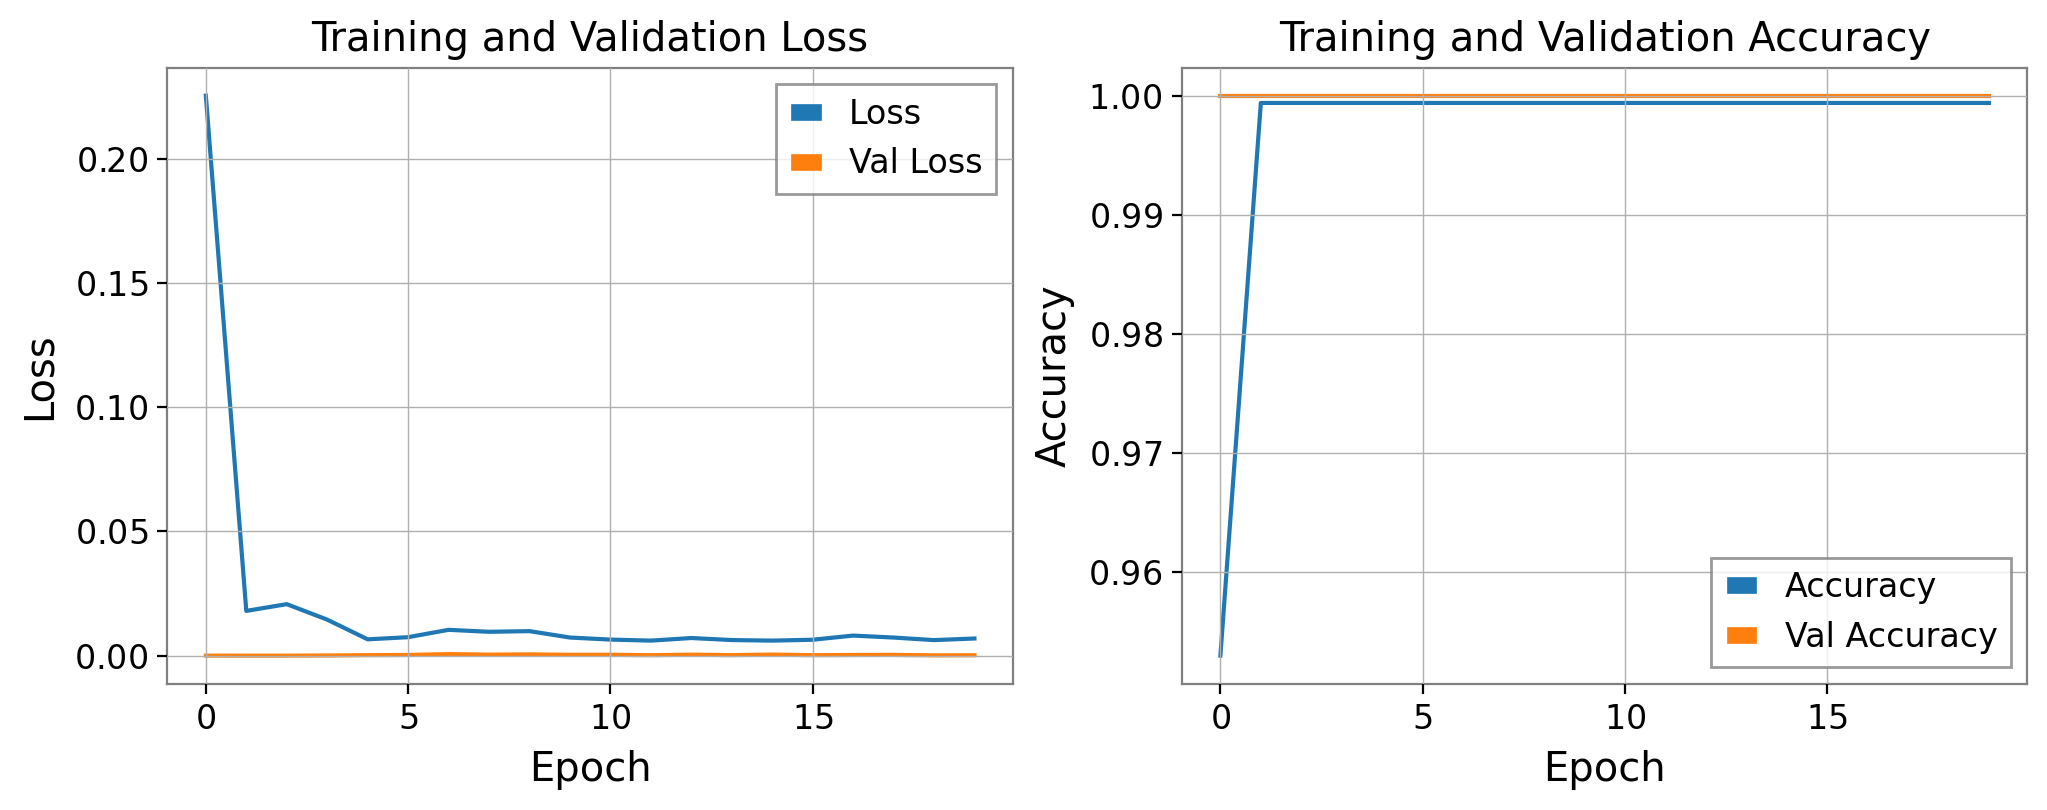

In [ ]:
# Build 2D CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(spectrograms.shape[1], X_train_aug.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train_aug, y_train_aug, epochs=20, batch_size=256, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


## Final Product

In [ ]:
save_and_verify_model('gw_2d_cnn.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as gw_2d_cnn.h5
Model loaded from gw_2d_cnn.h5
13/13 [==============================] - 0s 6ms/step - loss: 1.6660e-04 - accuracy: 1.0000
Loaded Model Test Loss: 0.00016660145774949342, Loaded Model Test Accuracy: 1.0


# 1D CNN

## Data Preparation (time-series data)

In [ ]:
# Reshape segments for 1D CNN
segments = segments.reshape((segments.shape[0], segments.shape[1], 1))

print(f"Reshaped segments shape: {segments.shape}")


Reshaped segments shape: (2047, 8192, 1)


In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)

## Data Augmentation

In [ ]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)

print(f"Original training data shape: {X_train.shape}")
print(f"Augmented training data shape: {X_train_aug.shape}")


Original training data shape: (1637, 8192, 1)
Augmented training data shape: (4911, 8192, 1)


## Model Training & Evaluation

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 8190, 16)          64        
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4095, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 4093, 32)          1568      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 2046, 32)          0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 65472)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

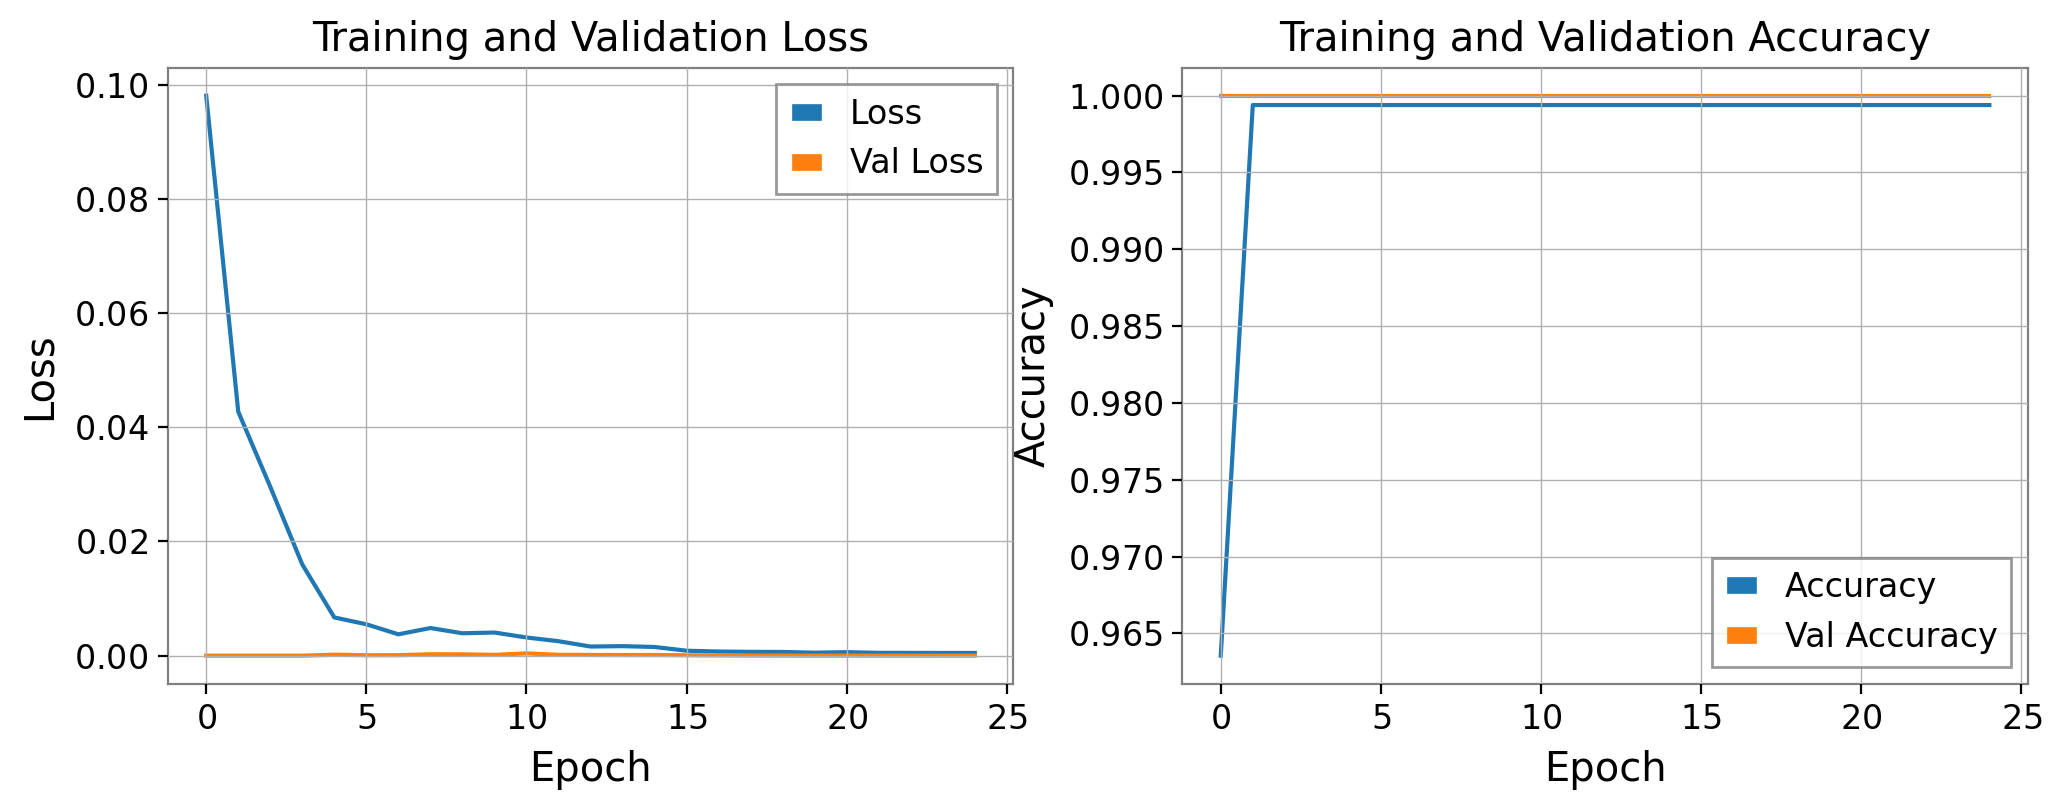

In [ ]:
# Build 1D CNN model
model = Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(segments.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train_aug, y_train_aug, epochs=25, batch_size=256, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


## Final Product

In [ ]:
save_and_verify_model('gw_1d_cnn.h5')


Model saved as gw_1d_cnn.h5
Model loaded from gw_1d_cnn.h5
13/13 [==============================] - 0s 5ms/step - loss: 6.1002e-06 - accuracy: 1.0000
Loaded Model Test Loss: 6.100245173001895e-06, Loaded Model Test Accuracy: 1.0
